In [2]:
pip install rasterio 

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
import rasterio as rio

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import minmax_scale
from sklearn import cluster
from sklearn.decomposition import PCA


In [4]:
# Importing the data
data_raster = rio.open('Playa_Image.tif')
# print(data_raster.meta)

## Visualizing the data
# Reading and enhancing
data_array = data_raster.read() # reading the data
# vmin, vmax = np.nanpercentile(data_array, (5,95)) # 5-95% pixel values stretch
# Plotting the enhanced image
# fig = plt.figure(figsize=[20,20])
# plt.axis('off')
# plt.imshow(data_array[1, :, :], cmap='gray', vmin=vmin, vmax=vmax)
# plt.show()

In [5]:
## Reshaping the input data from brc to rcb
# Creating an empty array with the same dimension and data type
imgxyb = np.empty((data_raster.height, data_raster.width, data_raster.count), data_raster.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = data_raster.read(band+1)

# Reshaping the input data from rcb to samples and features
data_reshaped = imgxyb.reshape(imgxyb.shape[0]*imgxyb.shape[1], -1)
# Scaling
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)

In [15]:
print(data_reshaped.shape)

(188788, 7)


In [6]:
def plot_data(data):
  fig = plt.figure(figsize = (15, 10))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

In [7]:
# PCA
pca = PCA(n_components=data_array.shape[0])
components = pca.fit_transform(data_reshaped)
var_ratio = pca.explained_variance_ratio_
values = pca.singular_values_


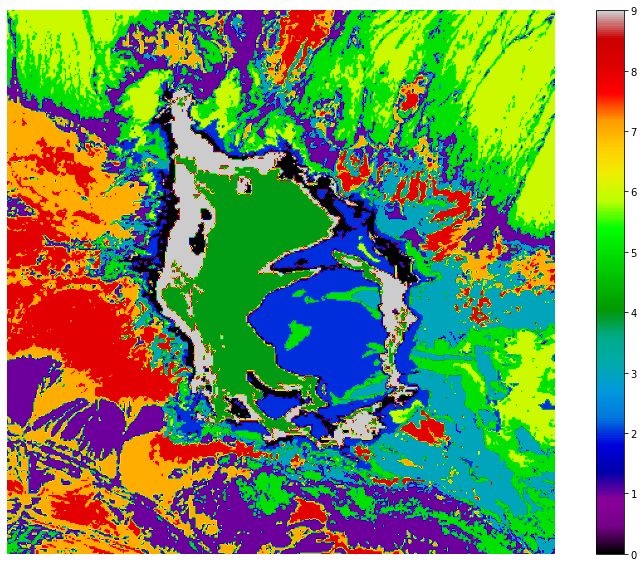

In [8]:
# K-means
cl = cluster.KMeans(n_clusters=10) # Creating an object of the classifier
components_num = 4
param = cl.fit(components[:,:components_num]) # Training
img_cl = cl.labels_ # Getting the labels of the classes
img_cl = img_cl.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl)

In [9]:
# Building the autoencoder
encoding_dim = 4

input_dim = Input(shape = (data_reshaped.shape[-1], ), name = 'InputLayer')

# Encoder layers
encoded1 = Dense(100, activation = 'relu', name = 'EncodeLayer1')(input_dim)
encoded2 = Dense(90, activation = 'relu', name = 'EncodeLayer2')(encoded1)
encoded3 = Dense(85, activation = 'relu', name = 'EncodeLayer3')(encoded2)
encoded4 = Dense(80, activation = 'relu', name = 'EncodeLayer4')(encoded3)
encoded5 = Dense(75, activation = 'relu', name = 'EncodeLayer5')(encoded4)
encoded6 = Dense(70, activation = 'relu', name = 'EncodeLayer6')(encoded5)

# Coded part
encoded7 = Dense(encoding_dim, activation = 'linear', name = 'CodeLayer')(encoded6)

# Decoder layers
decoded1 = Dense(70, activation = 'relu', name = 'DecodeLayer1')(encoded7)
decoded2 = Dense(75, activation = 'relu', name = 'DecodeLayer2')(decoded1)
decoded3 = Dense(80, activation = 'relu', name = 'DecodeLayer3')(decoded2)
decoded4 = Dense(85, activation = 'relu', name = 'DecodeLayer4')(decoded3)
decoded5 = Dense(90, activation = 'relu', name = 'DecodeLayer5')(decoded4)
decoded6 = Dense(100, activation = 'relu', name = 'DecodeLayer6')(decoded5)

decoded7 = Dense(data_reshaped.shape[-1], activation = 'sigmoid', name = 'OutputLayer')(decoded6)

In [10]:
# Combining encoder and deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded7)

autoencoder.summary()

# Compiling the model
autoencoder.compile(optimizer = 'adam', 
                    loss = 'mse', 
                    metrics = [tf.keras.metrics.MeanSquaredLogarithmicError()]
                    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 7)]               0         
                                                                 
 EncodeLayer1 (Dense)        (None, 100)               800       
                                                                 
 EncodeLayer2 (Dense)        (None, 90)                9090      
                                                                 
 EncodeLayer3 (Dense)        (None, 85)                7735      
                                                                 
 EncodeLayer4 (Dense)        (None, 80)                6880      
                                                                 
 EncodeLayer5 (Dense)        (None, 75)                6075      
                                                                 
 EncodeLayer6 (Dense)        (None, 70)                5320  

In [11]:
# Callbacks
## Early stopping
early_stop = EarlyStopping(monitor = 'mean_squared_logarithmic_error',
                            mode = 'min',
                            min_delta = 0,
                            patience = 5,
                            restore_best_weights = True)

## Checkpoint
checkpoint = ModelCheckpoint(filepath = 'Path/checkpoint.h5', 
                             monitor = 'mean_squared_logarithmic_error', 
                             mode ='min', 
                             save_best_only = True)

## Tensorboard
tensorboard = TensorBoard(log_dir='Path\{}'.format(time()))

In [12]:
# Fitting the model
hist = autoencoder.fit(data_reshaped, 
                       data_reshaped, 
                       epochs = 10, 
                       batch_size = 256, 
                       shuffle = True, 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

# Seperating the encoder part from the auto encoder model
encoder = Model(inputs = input_dim, outputs = encoded7)

Epoch 1/10
738/738 [==============================] - 6s 7ms/step - loss: 0.0029 - mean_squared_logarithmic_error: 0.0015
Epoch 2/10
738/738 [==============================] - 5s 7ms/step - loss: 2.4628e-04 - mean_squared_logarithmic_error: 1.3735e-04
Epoch 3/10
738/738 [==============================] - 5s 7ms/step - loss: 2.2685e-04 - mean_squared_logarithmic_error: 1.2840e-04
Epoch 4/10
738/738 [==============================] - 5s 7ms/step - loss: 2.1286e-04 - mean_squared_logarithmic_error: 1.2141e-04
Epoch 5/10
738/738 [==============================] - 5s 7ms/step - loss: 8.1824e-05 - mean_squared_logarithmic_error: 4.3348e-05
Epoch 6/10
738/738 [==============================] - 5s 7ms/step - loss: 4.3913e-05 - mean_squared_logarithmic_error: 2.1991e-05
Epoch 7/10
738/738 [==============================] - 5s 7ms/step - loss: 3.9771e-05 - mean_squared_logarithmic_error: 1.9935e-05
Epoch 8/10
738/738 [==============================] - 5s 7ms/step - loss: 3.8602e-05 - mean_square

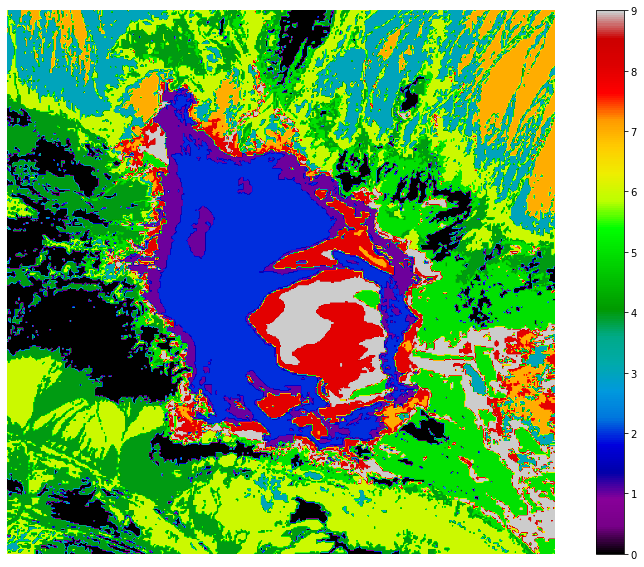

In [13]:
# Summary
# encoder.summary()

# Getting the data with the reduced dimesion
data_ae = encoder.predict(data_reshaped)

# K-means
cl = cluster.KMeans(n_clusters=10) # Creating an object of the classifier
param = cl.fit(data_ae) # Training
img_cl = cl.labels_ # Getting the labels of the classes
# img_cl_pred = cl.predict(data_ae)
img_cl = img_cl.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
import rasterio as rio

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import minmax_scale
from sklearn import cluster
from sklearn.decomposition import PCA

# Importing the data
data_raster = rio.open('Playa_Image.tif')
# print(data_raster.meta)

## Visualizing the data
# Reading and enhancing
data_array = data_raster.read() # reading the data
# vmin, vmax = np.nanpercentile(data_array, (5,95)) # 5-95% pixel values stretch
# Plotting the enhanced image
# fig = plt.figure(figsize=[20,20])
# plt.axis('off')
# plt.imshow(data_array[1, :, :], cmap='gray', vmin=vmin, vmax=vmax)
# plt.show()

## Reshaping the input data from brc to rcb
# Creating an empty array with the same dimension and data type
imgxyb = np.empty((data_raster.height, data_raster.width, data_raster.count), data_raster.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = data_raster.read(band+1)

# Reshaping the input data from rcb to samples and features
data_reshaped = imgxyb.reshape(imgxyb.shape[0]*imgxyb.shape[1], -1)
# Scaling
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)

def plot_data(data):
  fig = plt.figure(figsize = (15, 10))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

# PCA
pca = PCA(n_components=data_array.shape[0])
components = pca.fit_transform(data_reshaped)
var_ratio = pca.explained_variance_ratio_
values = pca.singular_values_

# K-means
cl = cluster.KMeans(n_clusters=10) # Creating an object of the classifier
components_num = 4
param = cl.fit(components[:,:components_num]) # Training
img_cl = cl.labels_ # Getting the labels of the classes
img_cl = img_cl.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl)

# Building the autoencoder
encoding_dim = 4

input_dim = Input(shape = (data_reshaped.shape[-1], ), name = 'InputLayer')

# Encoder layers
encoded1 = Dense(100, activation = 'relu', name = 'EncodeLayer1')(input_dim)
encoded2 = Dense(90, activation = 'relu', name = 'EncodeLayer2')(encoded1)
encoded3 = Dense(85, activation = 'relu', name = 'EncodeLayer3')(encoded2)
encoded4 = Dense(80, activation = 'relu', name = 'EncodeLayer4')(encoded3)
encoded5 = Dense(75, activation = 'relu', name = 'EncodeLayer5')(encoded4)
encoded6 = Dense(70, activation = 'relu', name = 'EncodeLayer6')(encoded5)

# Coded part
encoded7 = Dense(encoding_dim, activation = 'linear', name = 'CodeLayer')(encoded6)

# Decoder layers
decoded1 = Dense(70, activation = 'relu', name = 'DecodeLayer1')(encoded7)
decoded2 = Dense(75, activation = 'relu', name = 'DecodeLayer2')(decoded1)
decoded3 = Dense(80, activation = 'relu', name = 'DecodeLayer3')(decoded2)
decoded4 = Dense(85, activation = 'relu', name = 'DecodeLayer4')(decoded3)
decoded5 = Dense(90, activation = 'relu', name = 'DecodeLayer5')(decoded4)
decoded6 = Dense(100, activation = 'relu', name = 'DecodeLayer6')(decoded5)

decoded7 = Dense(data_reshaped.shape[-1], activation = 'sigmoid', name = 'OutputLayer')(decoded6)

# Combining encoder and deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded7)

autoencoder.summary()

# Compiling the model
autoencoder.compile(optimizer = 'adam', 
                    loss = 'mse', 
                    metrics = [tf.keras.metrics.MeanSquaredLogarithmicError()]
                    )

# Callbacks
## Early stopping
early_stop = EarlyStopping(monitor = 'mean_squared_logarithmic_error',
                            mode = 'min',
                            min_delta = 0,
                            patience = 5,
                            restore_best_weights = True)

## Checkpoint
checkpoint = ModelCheckpoint(filepath = 'Path/checkpoint.h5', 
                             monitor = 'mean_squared_logarithmic_error', 
                             mode ='min', 
                             save_best_only = True)

## Tensorboard
tensorboard = TensorBoard(log_dir='Path\{}'.format(time()))

# Fitting the model
hist = autoencoder.fit(data_reshaped, 
                       data_reshaped, 
                       epochs = 10, 
                       batch_size = 256, 
                       shuffle = True, 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

# Seperating the encoder part from the auto encoder model
encoder = Model(inputs = input_dim, outputs = encoded7)

# Summary
# encoder.summary()

# Getting the data with the reduced dimesion
data_ae = encoder.predict(data_reshaped)

# K-means
cl = cluster.KMeans(n_clusters=10) # Creating an object of the classifier
param = cl.fit(data_ae) # Training
img_cl = cl.labels_ # Getting the labels of the classes
# img_cl_pred = cl.predict(data_ae)
img_cl = img_cl.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl)